We will build a Neural Net today from abosulte Basics and scratch 

In [615]:
#First import the common headers we will be using
import math 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

We will start with the absoulte basics of defining a typical function and finding its gradient using first principle 

In [616]:
#Defining a function
def f(x):
    return 3*x**2 - 4*x +5

In [617]:
#Calling the function
f(3)

20

In [618]:
#Calling the function on certain points
xs=np.arange(-5,5,0.25)
ys=f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

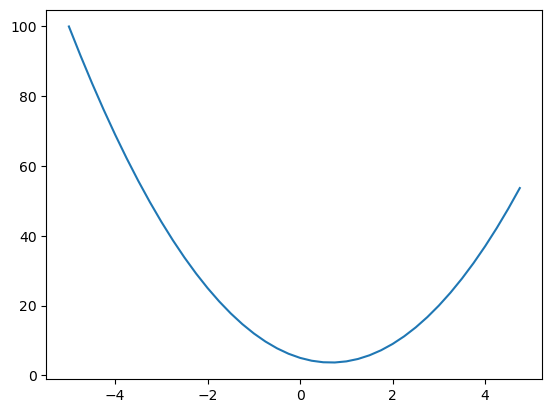

In [619]:
#Plotting the function
plt.plot(xs,ys)

In [620]:
#Calculating the derivative at x, using first principle : derivative=(f(x+h)-f(x))/h
h=0.0000001
x=3
derivative=(f(x+h)-f(x))/h
print(derivative)

14.000000305713911


In [621]:
#Writing some slighly more complicated cases to calculate derivatives
a=2
b=-3
c=10
d=a*b+c
print(d)

4


In [622]:
#Finding derivative of d with respect to a again using first principle
h=0.0001

#Inputs
a=2
b=-3
c=10

d1=a*b+c
a+=h
d2=a*b+c

print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)


d1 4
d2 3.999699999999999
slope -3.000000000010772


Defining a class Value (we will keep adding parameters as we go on)

In [623]:
#A very basic class value with just the initialisation and the representation given
class Value:

    def __init__(self,data):
        self.data=data
    
    def __repr__(self):
        return f"Value(data={self.data})"

#Testing
a=Value(2)
b=Value(3)
a
b

Value(data=3)

In [624]:
#Adding Addition and Multiplication to this class 

class Value:

    def __init__(self,data):
        self.data=data
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data)
        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data)
        return out

#Testing 
a=Value(2)
b=Value(3)
c=Value(4)
print(a+b)
print(a*b)
d=a*b+c
d
#(a.__mul__(b)).__add__(c) -> This is how it will call it behind the hood

Value(data=5)
Value(data=6)


Value(data=10)

In [625]:
#Now we add children to find out which node came from where
class Value:

    def __init__(self,data,_children=()):
        self.data=data
        self._prev=set(_children)
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other))
        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other))
        return out
    
a=Value(2)
b=Value(3)
c=Value(4)
d=a*b+c
d._prev

{Value(data=4), Value(data=6)}

In [626]:
#Now we add the operator and label as well -> to know which operator created which node and also assign labels to the nodes
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other),'+')
        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other),'*')
        return out
    
a=Value(2,label='a')
b=Value(3,label='b')
c=Value(4,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2,label='f')
L=d*f;L.label='L'
print(d._prev)
print(d._op)
print(d.label)

{Value(data=4), Value(data=6)}
+
d


In [627]:
#This is some code to draw the nodes in a graphical format
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s| data %.4f}" %(n.label,n.data,), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

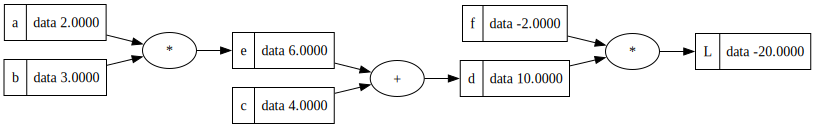

In [628]:
#Testing
draw_dot(L)

In [629]:
#We need to do back propogation now so we add a grad also in the class
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad = 0.0
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other),'+')
        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other),'*')
        return out
    
a=Value(2,label='a')
b=Value(3,label='b')
c=Value(4,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(-2,label='f')
L=d*f;L.label='L'
print(d._prev)
print(d._op)
print(d.label)

{Value(data=6), Value(data=4)}
+
d


In [630]:
#The graphing function after adding grad(ient)

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s| data %.4f|grad %.4f}" %(n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

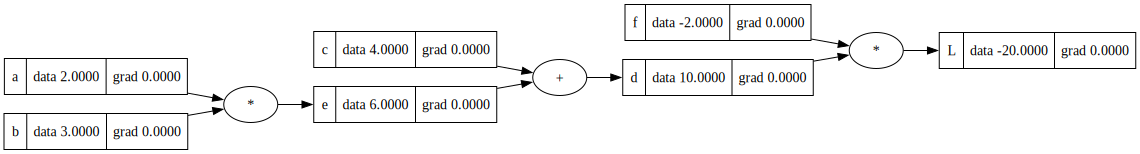

In [631]:
draw_dot(L)

In [632]:
#First when we do manual back propogation, we get these values 
L.grad=1.0
f.grad=10.0 #d
d.grad=-2.0 #f
e.grad=-2.0 #Grad of d
c.grad=-2.0 #Grad of d
a.grad=-6.0
b.grad=-4.0
#Call the above graphing function again to see these in the graph

In [633]:
#This is a finding derivative test function where we can increment the value by h in any variable in the 2nd part of the function to get the derivative of L with respect to that variable
#In this example, we have done it for e
def findingderivative():

    h=0.001
    a=Value(2,label='a')
    b=Value(3,label='b')
    c=Value(4,label='c')
    e=a*b;e.label='e'
    d=e+c;d.label='d'
    f=Value(-2,label='f')
    L=d*f;L.label='L'
    L1=L.data

    a=Value(2,label='a')
    b=Value(3,label='b')
    c=Value(4,label='c')
    e=a*b;e.label='e'
    e.data+=h
    d=e+c;d.label='d'
    f=Value(-2,label='f')
    L=d*f;L.label='L'
    L2=L.data

    print((L2-L1)/h)

findingderivative()

-2.0000000000024443


Now looking at it in a real neuron perspective 

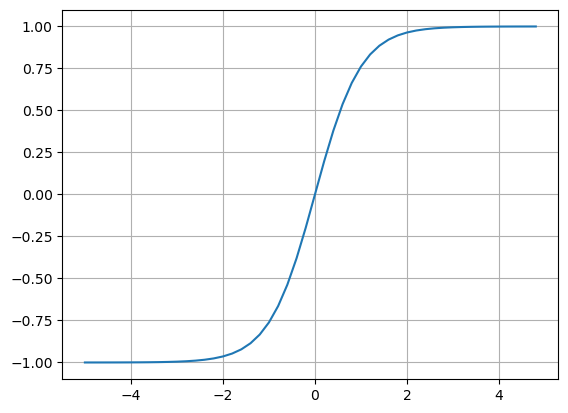

In [634]:
#Just plotting tanh to show you how squashing function looks like
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

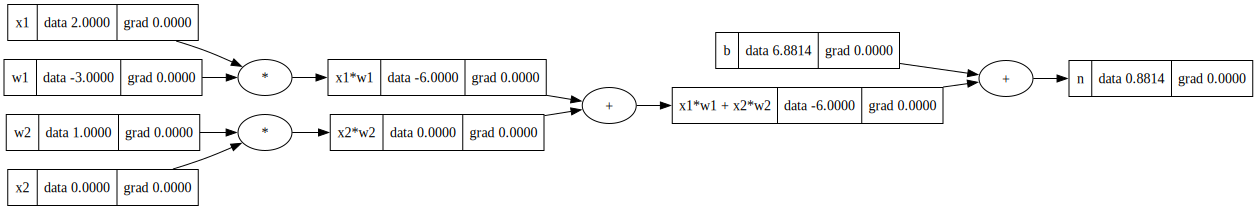

In [635]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
draw_dot(n)


In [636]:
#Adding Tanh also to the class
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad = 0.0
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other),'+')
        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other),'*')
        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')
        return out

In [637]:
#Seeing the same example with tanh also now

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label='o'

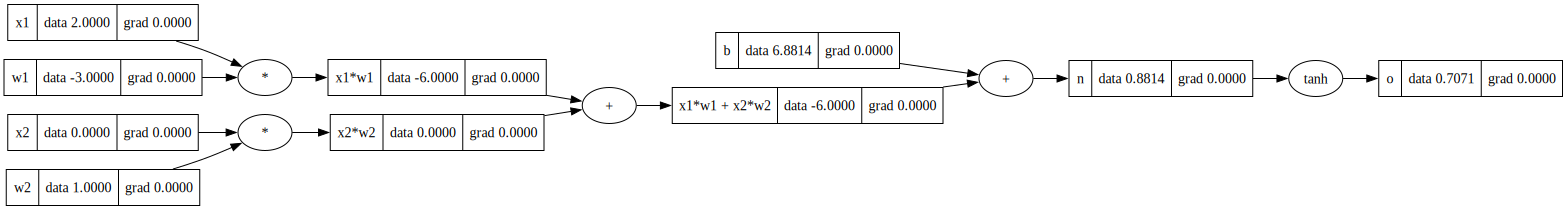

In [638]:
draw_dot(o)

In [639]:
#Manual gradient finding
o.grad=1.0
#Differentiation in tanh -> 1-tanh(x)^2
n.grad=1-o.data**2
x1w1x2w2.grad=0.5
b.grad=0.5
x1w1.grad=0.5
x2w2.grad=0.5
x1.grad=w1.data*0.5
w1.grad=x1.data*0.5
x2.grad=w2.data*0.5
w2.grad=x2.data*0.5

#Run the above graphing code after running this to see the graph with the gradients

How to do this backpropogation in system instead of manually

In [640]:
#Adding backward functions in all the def's so that we can find the gradient - for multiplication, accordingly, for addition, accordingly and similar for the rest
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad = 0.0
        self._backward=lambda:None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad=1.0*out.grad
            other.grad=1.0*out.grad
        out._backward= _backward

        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other),'*')

        def _backward():
            self.grad=other.data*out.grad
            other.grad=self.data*out.grad
        out._backward= _backward

        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')

        def _backward():
            self.grad=(1-t**2)*out.grad
        out._backward= _backward

        return out

In [641]:
#Again testing this with the new function

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label='o'

In [642]:
o.grad=1.0 #Base Case
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

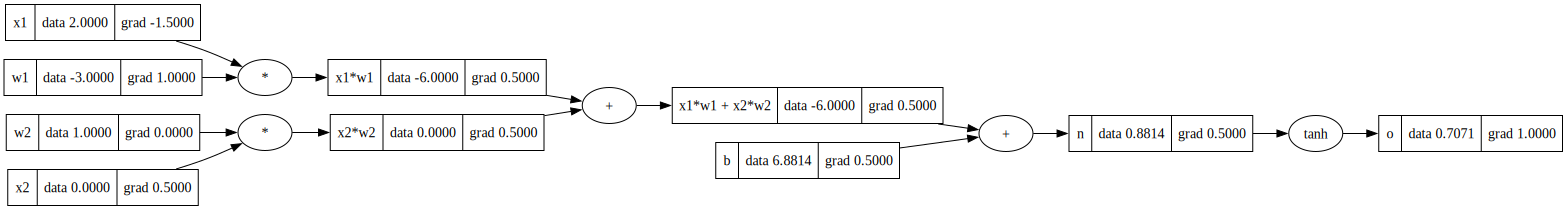

In [643]:
draw_dot(o)

Topological Sort

In [644]:
#Adding code for topological sorting so that we can just call backward once in the final node and the rest automatically happen 

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
build_topo(o)
topo


[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [645]:
#Rewriting the code using Topological
o.grad=1

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
   node._backward()

In [646]:
#Adding the functionality of topological into the class:
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad = 0.0
        self._backward=lambda:None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad=1.0*out.grad
            other.grad=1.0*out.grad
        out._backward= _backward

        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other),'*')

        def _backward():
            self.grad=other.data*out.grad
            other.grad=self.data*out.grad
        out._backward= _backward

        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')

        def _backward():
            self.grad=(1-t**2)*out.grad
        out._backward= _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [647]:
#Testing after adding topological

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o=n.tanh();o.label='o'

In [648]:
#Just calling output's backward is enough now 

o.backward()

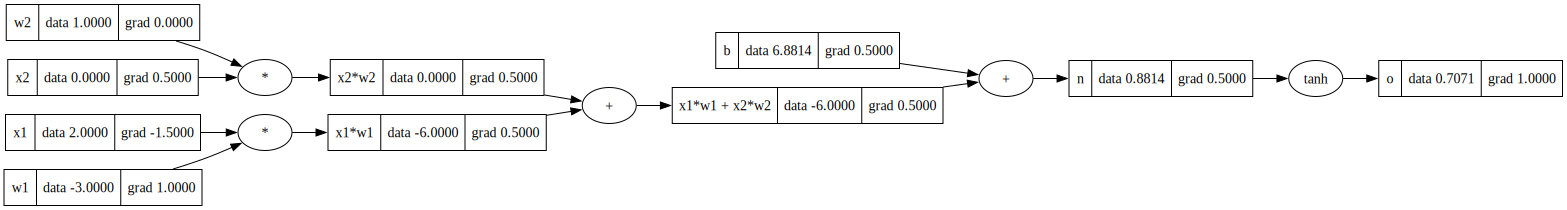

In [649]:
draw_dot(o)

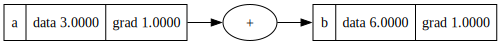

In [ ]:
#We discovered a bug:

a=Value(3.0,label='a')
b=a+a ; b.label='b'
b.backward()
draw_dot(b)

#But the actual grad of a should be 2 not 1 

In [652]:
#Anytime we use a variable more than once, we will see an issue 

In [ ]:
#Fixing this issue: instead of self.grad=(something)*out.grad -> We change it to self.grad+=(something)*out.grad

class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad = 0.0
        self._backward=lambda:None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad+=1.0*out.grad #We make changes here as we need to accumulate gradients if there are multiple mentions types 
            other.grad+=1.0*out.grad 
        out._backward= _backward

        return out
    
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other),'*')

        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward= _backward

        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out=Value(t,(self,),'tanh')

        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward= _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

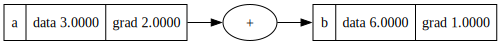

In [ ]:
#Bug Fixed now:
a=Value(3.0,label='a')
b=a+a ; b.label='b'
b.backward()
draw_dot(b)

In [655]:
#Breaking down tanh and implementing e^x & ( Adding a component in add and mul and also rmul for making things simpler )
#Division is basically a*1/b = a*b^-1
class Value:

    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self.grad = 0.0
        self._backward=lambda:None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad+=1.0*out.grad #We make changes here as we need to accumulate gradients if there are multiple mentions types 
            other.grad+=1.0*out.grad 
        out._backward= _backward

        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')

        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward= _backward

        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __truediv__(self,other):
        return self*other**-1
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self+(-other)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out=Value(self.data**other,(self,),f"**{other}")

        def _backward():
            self.grad+=other*self.data**(other-1)*out.grad
        out._backward=_backward

        return out
    
    def tanh(self):
        x=self.data
        #t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        t=math.tanh(x)
        out=Value(t,(self,),'tanh')

        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward= _backward

        return out
    
    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad+=math.exp(x)*out.grad
        out._backward=_backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
#We have modified the code in such a way that we can directly add numbers to these variables and not just 'Value' objects
a=Value(2)
print(a+1)
print(a*2)
print(2*a)
print(a/2)
print(a-1)


Value(data=3)
Value(data=4)
Value(data=4)
Value(data=1.0)
Value(data=1)


In [ ]:
#Just running the code finally once

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e=(2*n).exp()
o=(e-1)/(e+1);o.label='o'
o.backward()

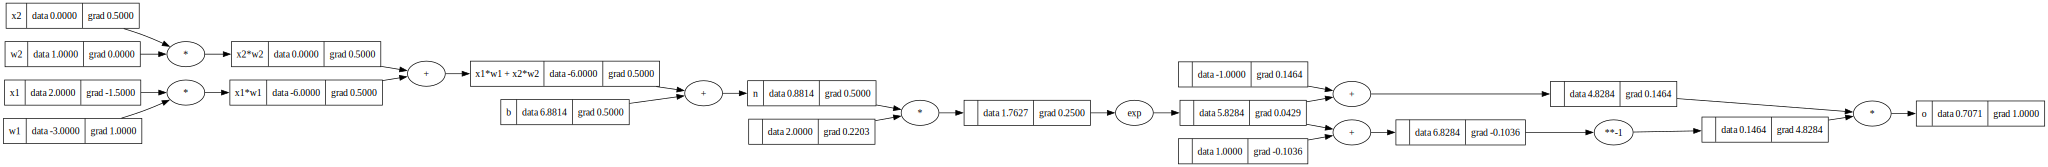

In [658]:
draw_dot(o)

Comparing with pytorch implementation

In [659]:
import torch

In [660]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [661]:
torch.Tensor([2.0])
torch.Tensor([2.0]).dtype

torch.float32

In [662]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True #By Default pytorch assumes leaf nodes do not need gradients - For efficieny reasons 
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print(o)
print(o.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358


In [663]:
import random

Starting the Neural Network ( First Neuron, then layer then Network )

In [ ]:
#We define a Neuron first ( we are calling it with random weights in the range of -1 to 1 )

class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        #call notation is for like n(x) type notation 
        #w*x + b  
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out 

x=[2.0,3.0]
n=Neuron(2)
n(x)
    

Value(data=-0.994176273392458)

In [ ]:
#Now we will implement a layer now - A Layer is nothing but a combination of Neurons 

class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        #call notation is for like n(x) type notation 
        #w*x + b  
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out 

class Layer:

    def __init__(self,nin,nout): #nout = number of neurons we want basically
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs
    
x=[2.0,3.0]
n=Layer(2,3)
n(x)

[Value(data=-0.9713937501279049),
 Value(data=-0.6610820052413641),
 Value(data=0.9732176671258029)]

In [ ]:
#Now Multi-Layer Perceptron: -> it is nothing but a combination of Layers 

class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        #call notation is for like n(x) type notation 
        #w*x + b  
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out 

class Layer:

    def __init__(self,nin,nout): #nout = number of neurons we want basically
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
class MLP:
    def __init__(self,nin,nouts): #nouts = number of neurons in each subsequent layer - it is a matrix like [4,4,1]
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
'''MLP Explanation:
sz = [nin] + nouts: This creates a list of all layer sizes. If nin=3 and nouts=[4, 4, 1], then sz becomes [3, 4, 4, 1].
self.layers: This uses a loop to connect the sizes.Layer 1: Input 3 $\rightarrow$ Output 4Layer 2: Input 4 $\rightarrow$ Output 4Layer 3: Input 4 $\rightarrow$ Output 1

__call__(self, x)
This implements the Forward Pass through the entire network.

The Loop: It takes the input x and passes it to the first layer.

x = layer(x): This is the crucial part. It overwrites x with the output of the current layer. The output of Layer 1 becomes the input for Layer 2, and so on.

The Result: After the loop finishes, x contains the final output of the very last layer.
'''
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.8928693132732969)

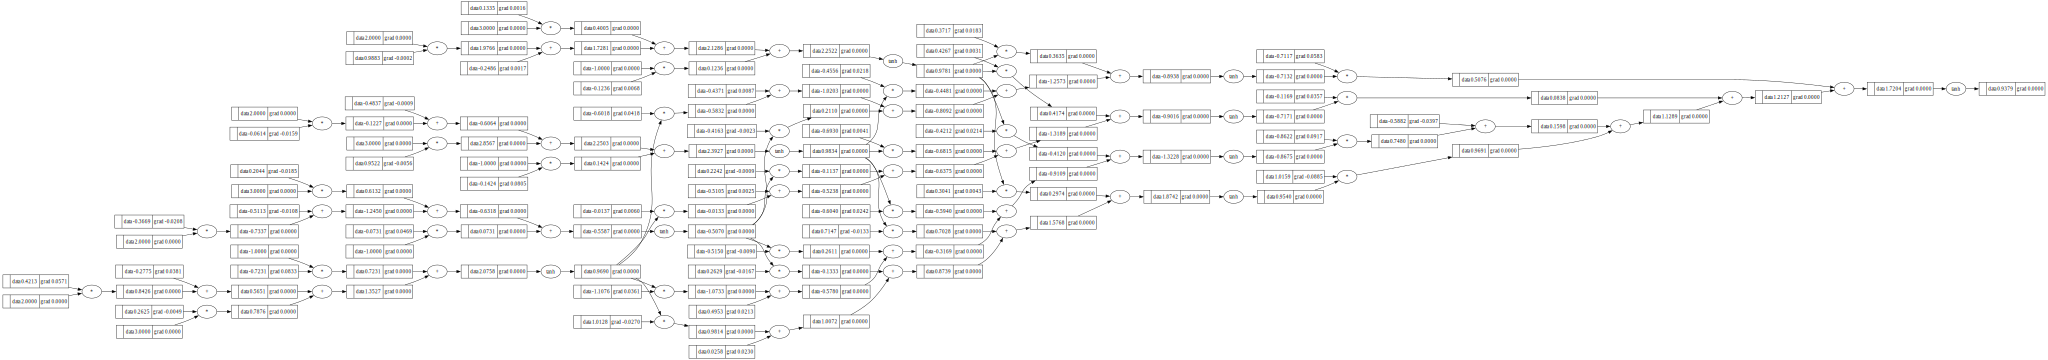

In [689]:
draw_dot(n(x))

In [ ]:
#Now we need to learn how to improvise the weights in a way that we want 
# We need to backpropogate and find the gradients 
# We need to fix the value of the weights using the gradients 

xs=[[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]] #inputs
ys=[1.0,-1.0,-1.0,1.0] # Desired targets 
ypred=[n(x) for x in xs]
ypred # We need to tune the weights in such a way that we get what we want 

[Value(data=-0.8928693132732969),
 Value(data=-0.5322002817474856),
 Value(data=-0.7730083978719285),
 Value(data=-0.7891117048708669)]

In [669]:
#Calculating the Loss for the above example:
loss = [(yout-ygt)**2 for ygt,yout in zip(ys,ypred)]
loss

[Value(data=3.5829542371317222),
 Value(data=0.2188365763971319),
 Value(data=0.051525187436668694),
 Value(data=3.20092069250594)]

In [670]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
loss # Higher loss = worse obviously 

Value(data=7.054236693471463)

In [ ]:
#Backpropogation to find the gradient of the Loss w.r.t the weights - which we will then use to modify the weights
loss.backward() 

In [ ]:
#This is how we can find the grad of any particular weight 
n.layers[0].neurons[0].w[0].grad

0.02606000291458401

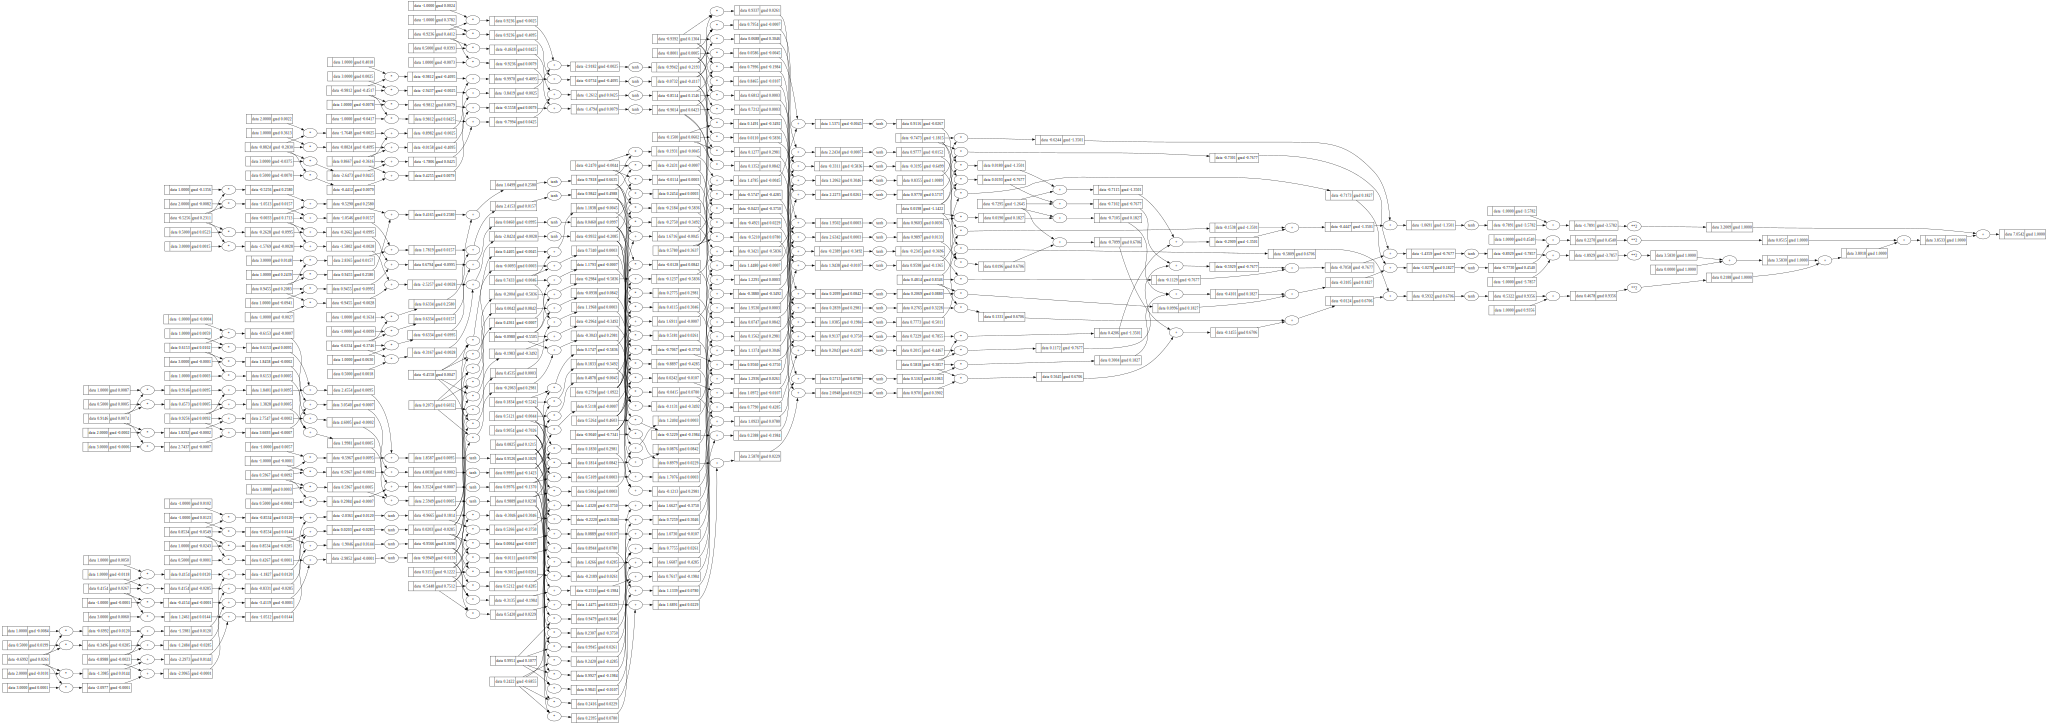

In [673]:
draw_dot(loss)

In [674]:
#We need to now modify the weights and play around:
class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        #call notation is for like n(x) type notation 
        #w*x + b  
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out 
    
    def parameters(self):
        return self.w+[self.b]

class Layer:

    def __init__(self,nin,nout): #nout = number of neurons we want basically
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        params=[]
        for neuron in self.neurons:
            ps=neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    def __init__(self,nin,nouts): #nouts = number of neurons in each subsequent layer - it is a matrix like [4,4,1]
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [690]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=0.14761934275569963)

In [ ]:
print(n.parameters())
print(len(n.parameters()))

[Value(data=0.1826115320231798), Value(data=0.2267657923234785), Value(data=0.3130866301786128), Value(data=-0.7616425045915511), Value(data=0.8672181565340253), Value(data=-0.48542818705973856), Value(data=-0.13188104451936655), Value(data=-0.26603869529614244), Value(data=0.6615414086404519), Value(data=-0.45663536982218234), Value(data=0.11010546436650137), Value(data=-0.06034370546837842), Value(data=-0.862893861743772), Value(data=-0.8148590556402728), Value(data=-0.3564350753084067), Value(data=0.42661711126234336), Value(data=-0.6204150786111737), Value(data=-0.2783240317720508), Value(data=-0.35105896630076416), Value(data=-0.9956739048612895), Value(data=0.9983594329838616), Value(data=-0.486059768548067), Value(data=0.6719354067938095), Value(data=0.09790357978545572), Value(data=-0.9748082680248071), Value(data=0.9176021183347309), Value(data=0.18231071791676023), Value(data=-0.8014508432331866), Value(data=-0.8176974347068153), Value(data=0.8177480913162953), Value(data=0.8

In [677]:
#Now we need to backpropogate 
xs=[[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]] #inputs
ys=[1.0,-1.0,-1.0,1.0] # Desired targets 
ypred=[n(x) for x in xs]
ypred # We need to tune the weights in such a way that we get what we want 
print(ypred)
len(n.parameters())

[Value(data=-0.3674684608185492), Value(data=0.627200118675036), Value(data=-0.8575727195550509), Value(data=0.20481997124968596)]


41

In [678]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
loss # Higher loss = worse obviously 

Value(data=5.170347025887798)

In [679]:
loss.backward()

In [680]:
n.layers[0].neurons[0].w[0].data

-0.7850065362016192

In [681]:
for p in n.parameters():
    p.data+=-0.001*p.grad

In [682]:
loss.backward()

In [683]:
n.layers[0].neurons[0].w[0].data #We notice how it has changed a litrle

-0.7858031082615815

In [684]:
ypred=[n(x) for x in xs]
ypred
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
loss # We see that it has decreased - so we are going in the right direction 

Value(data=5.093831558678249)

In [685]:
ypred

[Value(data=-0.347323273787816),
 Value(data=0.6259610917894697),
 Value(data=-0.8553417405755627),
 Value(data=0.2164975618704054)]

In [ ]:
#Now mixing everything into a single unit: and doing stochastic gradient descent to improvise our weights 

xs=[[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]] #inputs
ys=[1.0,-1.0,-1.0,1.0]
n=MLP(3,[4,4,1])

for k in range(40):
    #forward pass:
    ypred=[n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))

    #Backward Pass:
    loss.backward()

    #update:
    for p in n.parameters():
        p.data+=-0.01*p.grad

    print(k,loss.data)

0 3.5382903921186064
1 3.1528432105926445
2 2.5308288560512997
3 1.9763007186822397
4 1.5541025275698441
5 0.9956306676606785
6 0.40421769687014103
7 0.11515985624650027
8 0.029929494656701666
9 0.007960782552756127
10 0.002264104959516272
11 0.0006962841169839321
12 0.0002296210009109942
13 8.003420088100271e-05
14 2.9091598367054242e-05
15 1.0915754529760095e-05
16 4.197498380798669e-06
17 1.6458978990793571e-06
18 6.558255909965142e-07
19 2.649103561254464e-07
20 1.0829077273350219e-07
21 4.4743176793253425e-08
22 1.8668177631167367e-08
23 7.859650166331155e-09
24 3.337143255674947e-09
25 1.428226818778419e-09
26 6.158469431973447e-10
27 2.6743496337639383e-10
28 1.1691221337348543e-10
29 5.143202963409162e-11
30 2.2760723199250944e-11
31 1.0129248270961513e-11
32 4.531943109595786e-12
33 2.0380080972209347e-12
34 9.210093018124902e-13
35 4.1822357396716035e-13
36 1.9081779623478523e-13
37 8.747950255565418e-14
38 4.03009315131402e-14
39 1.8660509697982683e-14


In [687]:
ypred

[Value(data=0.9999999726673685),
 Value(data=-0.9999999262863036),
 Value(data=-0.9999998915704174),
 Value(data=0.9999999731159243)]

In [ ]:
#Fixing an error - zerograd before doing loss.backward()

xs=[[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0]] #inputs
ys=[1.0,-1.0,-1.0,1.0]
n=MLP(3,[4,4,1])

for k in range(100):
    #forward pass:
    ypred=[n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))

    #Backward Pass:
    for p in n.parameters():
        p.grad=0
    loss.backward()

    #update:
    for p in n.parameters():
        p.data+=-0.01*p.grad

    print(k,loss.data)

0 6.787861137082545
1 6.533543945493397
2 6.2056768836445695
3 5.803324346995105
4 5.345299317638652
5 4.866224317567831
6 4.40038558550647
7 3.968472492973622
8 3.577577335695022
9 3.2279505973145266
10 2.9165780122928258
11 2.637367672475561
12 2.3823699782125556
13 2.1448623917569005
14 1.9217695209029912
15 1.7136660598944502
16 1.5228929785299956
17 1.3514554902378397
18 1.1999246997302437
19 1.0674354997086182
20 0.952214598182941
21 0.852133027857918
22 0.7650794504852099
23 0.6891488046662751
24 0.6227052664535278
25 0.5643773964898734
26 0.513024611675007
27 0.4676967014099432
28 0.4275964403202678
29 0.39204877313147823
30 0.36047684393856483
31 0.33238385613927673
32 0.3073394309403179
33 0.28496923986855494
34 0.2649469393314785
35 0.24698770062612513
36 0.2308428531508538
37 0.21629532743792132
38 0.20315570154224555
39 0.1912587296869513
40 0.1804602774263705
41 0.17063461302247326
42 0.16167201795810887
43 0.15347668589389674
44 0.14596488233880603
45 0.13906333884883268

Summary:
Neural Nets are basically mathematical expressions - that take input as the data ( use some weights ) and give out some output